# Binary Human-Written vs Machine-Generated Text Classification - Data Exploration

### Imports

In [3]:
# Run this cell to install the required packages

# !pip install ipywidgets

In [4]:
# Uncomment this cell to mount your google drive in colab

# from google.colab import drive
# drive.mount('/content/drive')

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from nltk.tokenize import word_tokenize

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

from ipywidgets import interact

from lightning import LightningModule
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from torchmetrics import Accuracy, F1Score

from transformers import AutoTokenizer, AutoModelForSequenceClassification, BitsAndBytesConfig

from peft import LoraModel, LoraConfig

## Data Loading

In [30]:
data_folder = "./data"
train_df = pd.read_json(path_or_buf=f'{data_folder}/subtaskA_train_monolingual.jsonl', lines=True)
train_df.set_index('id',inplace=True)

val_df = pd.read_json(path_or_buf=f'{data_folder}/subtaskA_dev_monolingual.jsonl', lines=True)
val_df.set_index('id',inplace=True)

test_df = pd.read_json(path_or_buf=f'{data_folder}/subtaskA_test_monolingual.jsonl', lines=True)
test_df.set_index('id',inplace=True)

In [31]:
train_df.head()

,text,label,model,source
id,,,,
0,Forza Motorsport is a popular racing game that...,1,chatGPT,wikihow
1,Buying Virtual Console games for your Nintendo...,1,chatGPT,wikihow
2,Windows NT 4.0 was a popular operating system ...,1,chatGPT,wikihow
3,How to Make Perfume\n\nPerfume is a great way ...,1,chatGPT,wikihow
4,How to Convert Song Lyrics to a Song'\n\nConve...,1,chatGPT,wikihow


In [32]:
val_df.head()

,text,label,model,source
id,,,,
0,Giving gifts should always be enjoyable. Howe...,1,bloomz,wikihow
1,Yveltal (Japanese: ユベルタル) is one of the main a...,1,bloomz,wikihow
2,If you'd rather not annoy others by being rude...,1,bloomz,wikihow
3,If you're interested in visiting gravesite(s) ...,1,bloomz,wikihow
4,The following are some tips for becoming succe...,1,bloomz,wikihow


In [33]:
test_df.head()

,text,label
id,,
0,"Today, many adults or teenage drivers are hook...",0
1,"The automobile, since its advent, has revoluti...",1
2,One policy that could potentially improve aca...,1
3,Title: Navigating the Road Ahead: The Case for...,1
4,Have you ever woken up in the morning and wish...,0


In [34]:
@interact(i=(0, len(train_df)-1, 1))
def print_datapoint(i):
    d = {k: v for k, v in train_df.loc[i].items()}
    return d

interactive(children=(IntSlider(value=59878, description='i', max=119756), Output()), _dom_classes=('widget-in…

In [35]:
@interact(i=(0, len(val_df)-1, 1))
def print_datapoint(i):
    d = {k: v for k, v in val_df.loc[i].items()}
    return d

interactive(children=(IntSlider(value=2499, description='i', max=4999), Output()), _dom_classes=('widget-inter…

In [36]:
@interact(i=(0, len(test_df)-1, 1))
def print_datapoint(i):
    d = {k: v for k, v in test_df.loc[i].items()}
    return d

interactive(children=(IntSlider(value=17135, description='i', max=34271), Output()), _dom_classes=('widget-int…

In [37]:
def print_stats(df, name):
    print(f"Stats for {name} data:")
    print(f"Dataset size: {len(df)}")
    print(f"Percentage of texts labeled as 1s (machine generated): {len(df[df['label'] == 1])/len(df)*100:.2f}% \n")

In [38]:
print_stats(train_df, "training")
print_stats(val_df, "validation")
print_stats(test_df, "test")

Stats for training data:
Dataset size: 119757
Percentage of texts labeled as 1s (machine generated): 47.10% 

Stats for validation data:
Dataset size: 5000
Percentage of texts labeled as 1s (machine generated): 50.00% 

Stats for test data:
Dataset size: 34272
Percentage of texts labeled as 1s (machine generated): 52.52% 



### Plots

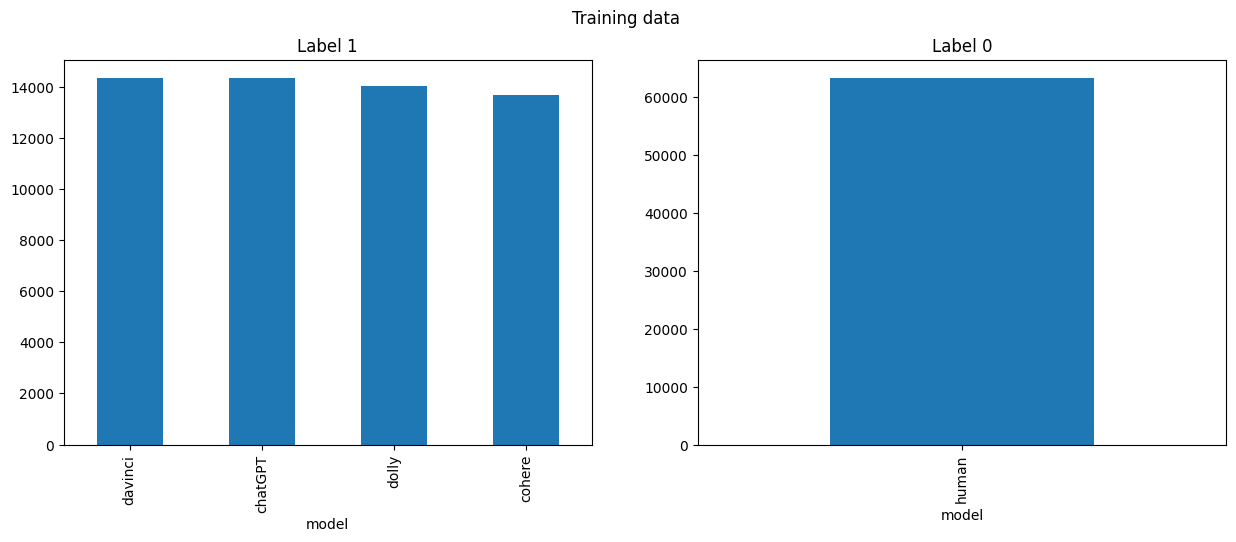

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

fig.suptitle('Training data')
train_df[train_df['label'] == 1]['model'].value_counts().plot(kind='bar', ax=axes[0], title='Label 1');
train_df[train_df['label'] == 0]['model'].value_counts().plot(kind='bar', ax=axes[1], title='Label 0');

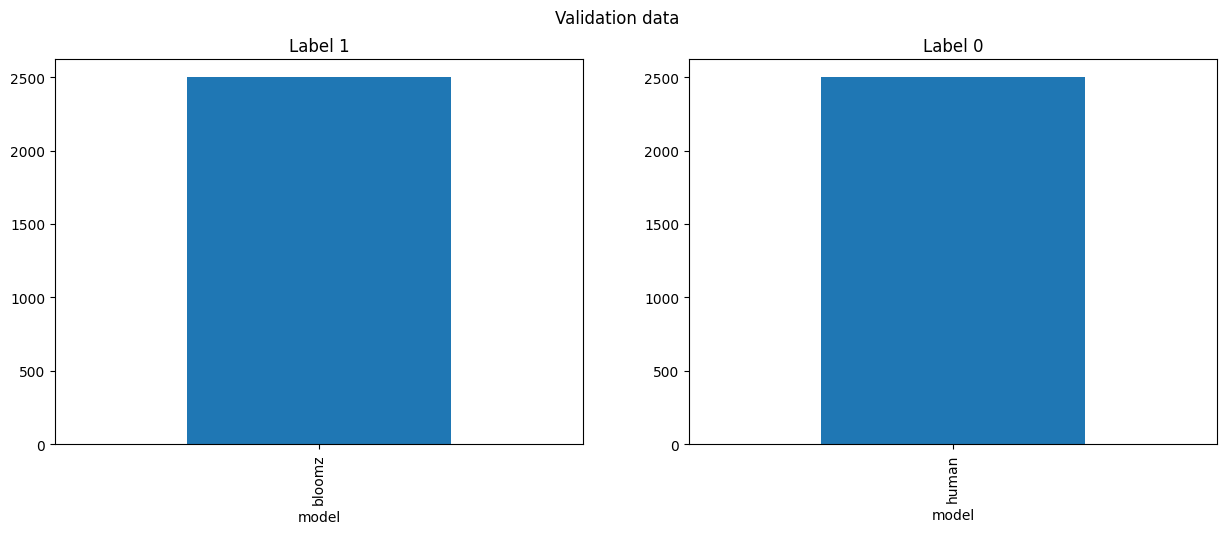

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

fig.suptitle('Validation data')
val_df[val_df['label'] == 1]['model'].value_counts().plot(kind='bar', ax=axes[0], title='Label 1');
val_df[val_df['label'] == 0]['model'].value_counts().plot(kind='bar', ax=axes[1], title='Label 0');

The validation data contains text generated from a different LLM, bloomz, not present in the models that generated texts for the training data

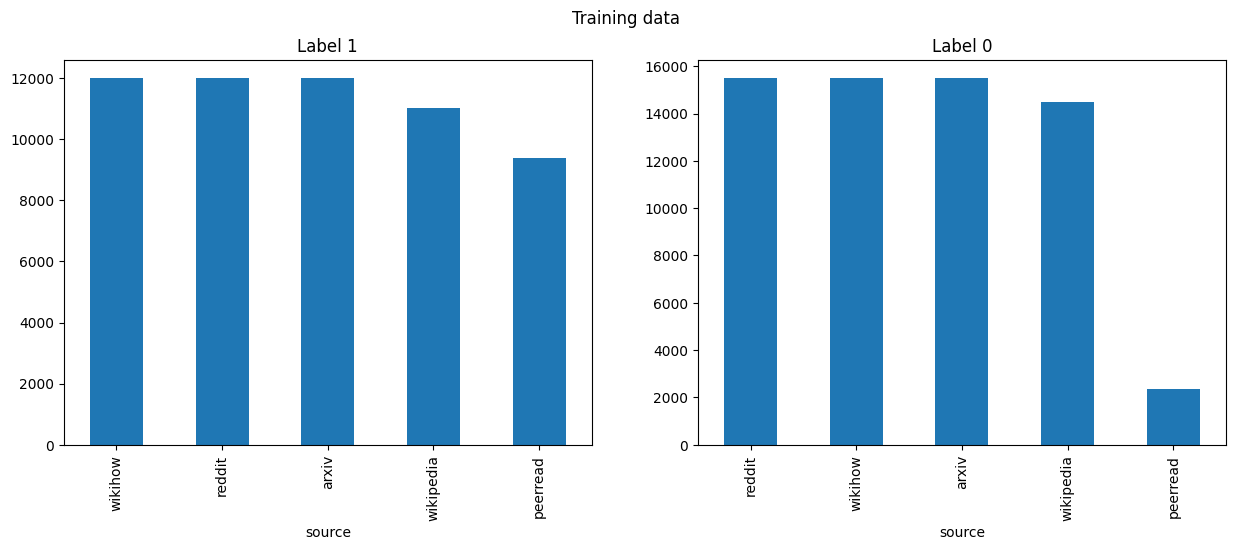

In [41]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

fig.suptitle('Training data')
train_df[train_df['label'] == 1]['source'].value_counts().plot(kind='bar', ax=axes[0], title='Label 1');
train_df[train_df['label'] == 0]['source'].value_counts().plot(kind='bar', ax=axes[1], title='Label 0');

Notice how we have a source imbalance, as there is much less data from the pearread source in the negative class subset

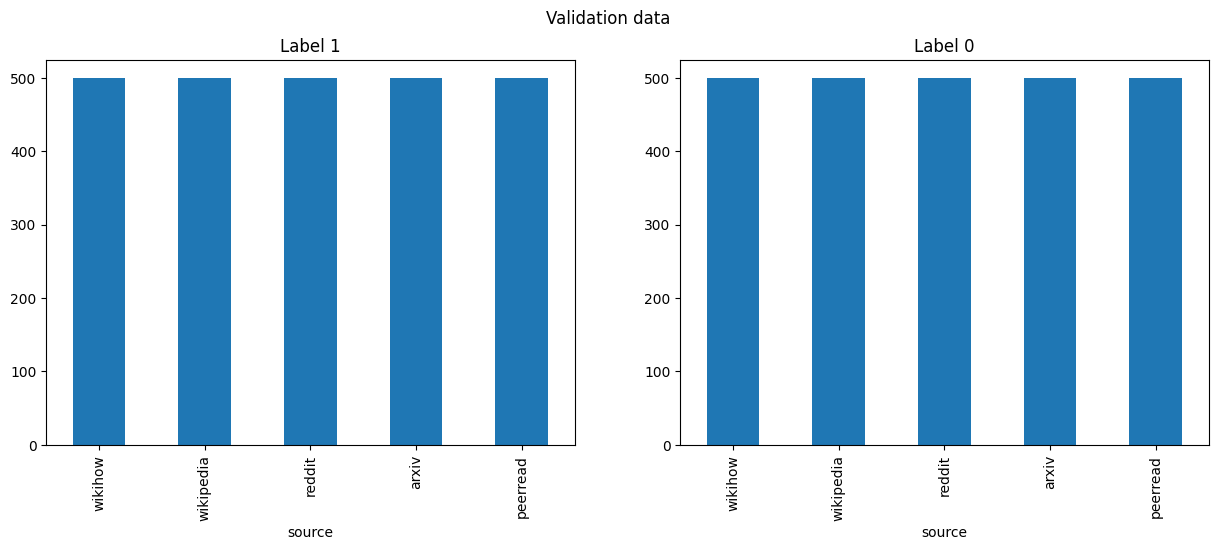

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

fig.suptitle('Validation data')
val_df[val_df['label'] == 1]['source'].value_counts().plot(kind='bar', ax=axes[0], title='Label 1');
val_df[val_df['label'] == 0]['source'].value_counts().plot(kind='bar', ax=axes[1], title='Label 0');

The training and validation datasets are pretty balanced with respect to the fields "model" and "source".

We ignore these two in the following steps, as the model will be fed only with text at test time, but keep them in the data to look for insights in the error analysis phase.

In [44]:
train_df['word_count'] = train_df['text'].apply(lambda text: len(word_tokenize(text)))
val_df['word_count'] = val_df['text'].apply(lambda text: len(word_tokenize(text)))
test_df['word_count'] = test_df['text'].apply(lambda text: len(word_tokenize(text)))

In [45]:
train_df.head()

,text,label,model,source,word_count
id,,,,,
0,Forza Motorsport is a popular racing game that...,1,chatGPT,wikihow,487
1,Buying Virtual Console games for your Nintendo...,1,chatGPT,wikihow,813
2,Windows NT 4.0 was a popular operating system ...,1,chatGPT,wikihow,1041
3,How to Make Perfume\n\nPerfume is a great way ...,1,chatGPT,wikihow,942
4,How to Convert Song Lyrics to a Song'\n\nConve...,1,chatGPT,wikihow,652


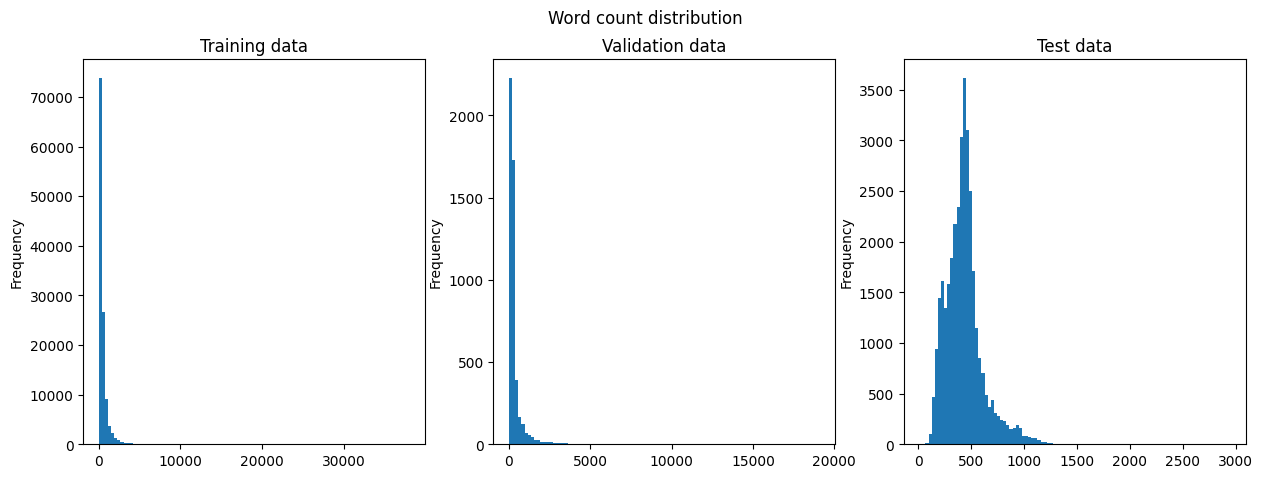

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

fig.suptitle('Word count distribution')
train_df['word_count'].plot(kind='hist', bins=100, ax=axes[0], title='Training data');
val_df['word_count'].plot(kind='hist', bins=100, ax=axes[1], title='Validation data');
test_df['word_count'].plot(kind='hist', bins=100, ax=axes[2], title='Test data');


      Plot considering 99.57% of the training data, 
      99.62% of the validation data
      and 100.00% of the test data.


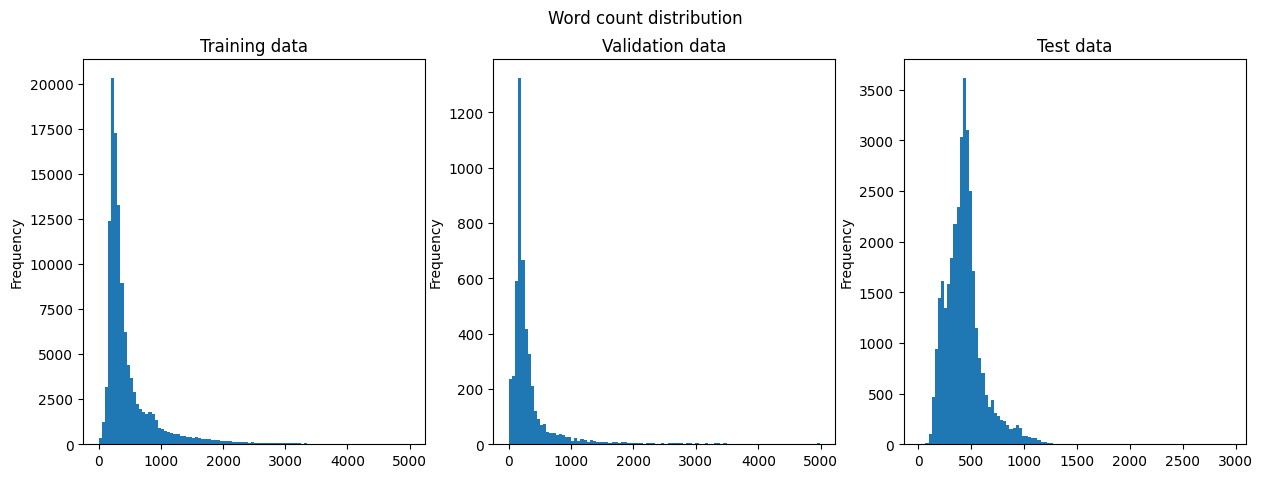

In [47]:
# Let's consider for a moment only the data below a certain threshold length (5000) for a more informative plot
print(f"""
      Plot considering {len(train_df[train_df['word_count'] < 5000]) / len(train_df) * 100 :.2f}% of the training data, 
      {len(val_df[val_df['word_count'] < 5000]) / len(val_df) * 100 :.2f}% of the validation data
      and {len(test_df[test_df['word_count'] < 5000]) / len(test_df) * 100 :.2f}% of the test data.""")

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

fig.suptitle('Word count distribution')
train_df[train_df['word_count'] < 5000]['word_count'].plot(kind='hist', bins=100, ax=axes[0], title='Training data');
val_df[val_df['word_count'] < 5000]['word_count'].plot(kind='hist', bins=100, ax=axes[1], title='Validation data');
test_df[test_df['word_count'] < 5000]['word_count'].plot(kind='hist', bins=100, ax=axes[2], title='Test data');

In [48]:
print("Word count statistics for training set:")
print(train_df['word_count'].describe())

print("\n")
print("Word count statistics for validation set:")
print(val_df['word_count'].describe())

print("\n")
print("Word count statistics for test set:")
print(test_df['word_count'].describe())

Word count statistics for training set:
count    119757.000000
mean        530.120202
std         761.001850
min           2.000000
25%         233.000000
50%         319.000000
75%         532.000000
max       38070.000000
Name: word_count, dtype: float64


Word count statistics for validation set:
count     5000.000000
mean       394.034000
std        710.770915
min          7.000000
25%        165.000000
50%        212.500000
75%        344.000000
max      19115.000000
Name: word_count, dtype: float64


Word count statistics for test set:
count    34272.000000
mean       437.334063
std        184.958018
min         12.000000
25%        322.000000
50%        424.000000
75%        505.000000
max       2946.000000
Name: word_count, dtype: float64


Training and testing data are similar, or at least compatible, in terms of word counts of the texts, with test data having a noticably smaller word count

In [49]:
train_df.drop(columns='word_count', inplace=True)
val_df.drop(columns='word_count', inplace=True)
test_df.drop(columns='word_count', inplace=True)